## Generate Zwift Workout Files from Strava Activities

Our goal here is a to build a tool that will automatically generate Zwift structured workouts based on actual outdoor activities. For example, this would allow us to practice the precise efforts associated with a specific race on the indoor trainer. All that is required in this example is a rider's power data from a past race we want to mirror in our training.

This notebook implements all of the steps required to generate such a Zwift workout. As input, you provide the data stream associated with a specific activity recorded on Strava. As output, you obtain a .zwo file that can be loaded into Zwift then selected as a structured workout within the Zwift application.

Note that all of the steps in this notebook are also implemented in the script `strava_to_zwo.py` within this repository.

<hr>

In [24]:
import json
import numpy as np
from scipy.signal import medfilt
from scipy import interpolate
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

<hr>

We will extract the recorded power output for a Strava activity by downloading the JSON-formatted stream for this activity. The easiest way to to this is to load the stream in your browser, then cut and paste the contents into a text editor or directly save the page. 

To access an activity stream, append `streams` to the URL of the activity page. For example, if the activity page is `https://www.strava.com/activities/2264175248`, the corresponding stream can be accessed at `https://www.strava.com/activities/2264175248/streams`.

In [25]:
activity_file = 'rc_fig_8.json'

In [26]:
f = open(activity_file,'r')
ride_json = f.read()
f.close()

ride = json.loads(ride_json)

for k in ride:
    ride[k] = [x if x!=None else 0 for x in ride[k]]

<hr>

Resample power, elevation, and distance to generate ride data sampled at 1 sec intervals. 

In [27]:
interp_watt = interpolate.interp1d(ride['time'],ride['watts'])
interp_alt = interpolate.interp1d(ride['time'],ride['altitude'])
interp_dist = interpolate.interp1d(ride['time'],ride['distance'])

max_t = max(ride['time'])
new_t = range(0,max_t)
new_p = interp_watt(new_t)
new_alt = interp_alt(new_t)
new_dist = interp_dist(new_t)

In [28]:
# Set minimum power to min_P
min_P = 100.0
new_p = np.maximum(min_P,new_p)

Plot power data for this activity. 

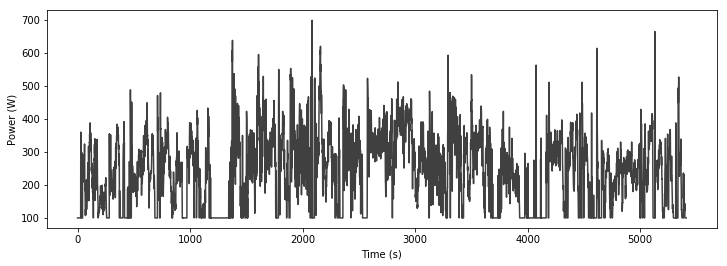

In [29]:
plt.figure(figsize=(12,4))
plt.plot(new_p, 'k', alpha=0.75)
plt.xlabel('Time (s)')
plt.ylabel('Power (W)')
plt.show()

As we can see, power data from "in real life" rides tends to be quite erratic. However, our aim here is to design a workout composed of a sequence of constant-power intervals that roughly replicates the effots of this ride.

To accomplish this, we will process our power data in several steps:
* First smooth the power data to reduce some of the noise
* Identify a small set of representitive power levels capturing the various levels of effort experienced through this ride. 
* Build a sequence of intervals from these representitive power levels, where each interval should be of a reasonable duration (e.g., durations ranging from 10 seconds to several minutes).

<hr>

First we will smooth the power data using a median filter...

In [30]:
sm_p = medfilt(new_p,21)

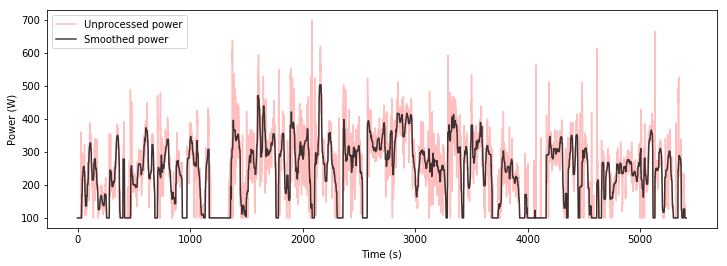

In [31]:
plt.figure(figsize=(12,4))
p1, = plt.plot(new_p, 'r', alpha=0.25)
p2, = plt.plot(sm_p, 'k', alpha=0.75)
plt.xlabel('Time (s)')
plt.ylabel('Power (W)')
plt.legend([p1, p2],['Unprocessed power', 'Smoothed power'])
plt.show()

Smoothing produces a slightly clearer view of the efforts put in throughout this ride. As a next step we will perform a clustering on the smoothed power to generate a collection of representative power levels from this ride...

<hr>

In [32]:
n_clusters = 7

In [33]:
kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(sm_p.reshape(-1, 1))

In [34]:
kmeans.cluster_centers_

array([[255.7152962 ],
       [155.57619048],
       [299.21370604],
       [407.16262976],
       [102.30034722],
       [210.20597015],
       [347.28482003]])

Generate a sequence of power levels quantized to cluster centers identified previously

In [35]:
q_p = [ float(kmeans.cluster_centers_[i]) for i in kmeans.predict(sm_p.reshape(-1,1)) ]

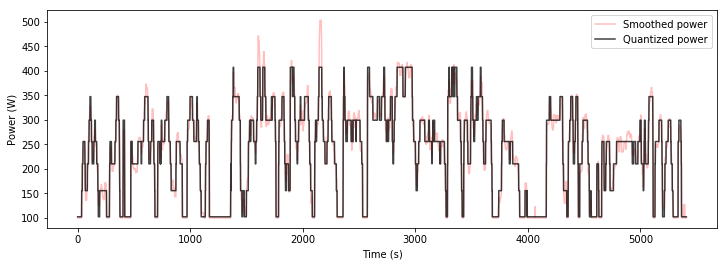

In [36]:
plt.figure(figsize=(12,4))
p1, = plt.plot(sm_p, 'r', alpha=0.25)
p2, = plt.plot(q_p, 'k', alpha=0.75)
plt.xlabel('Time (s)')
plt.ylabel('Power (W)')
plt.legend([p1, p2],['Smoothed power', 'Quantized power'])
plt.show()

This sequence of quantized power outputs should reasonably approximate the smoothed power sequence. Finally, we will adjust this sequence to elimimate any rapid switching among power levels.

As a first step, we will represent this power sequence as a sequence of intervals of the form: `(duration, power, distance, elevation change)`

In [37]:
segments = []
start_alt = new_alt[0]
start_dist = new_dist[0]

start = 0
this_val = q_p[0]
for i in range(1,len(q_p)):
    if q_p[i] != this_val:
        # Get differences in start and end values
        end_alt = new_alt[i]
        end_dist = new_dist[i]
        dist = (end_dist-start_dist)
        elev = (end_alt-start_alt)
        segments.append( [i-start,float(this_val),dist,elev] )
        # Reset new start values
        start = i
        start_alt = end_alt
        start_dist = end_dist
        this_val = q_p[i]
# Get differences for last segment
end_alt = new_alt[-1]
end_dist = new_dist[-1]
dist = (end_dist-start_dist)
alt = (end_alt-start_alt)
segments.append( [len(q_p)-1-start,float(this_val),dist,elev] )

Next we will merge all intervals with duration less than a given threshold with their neighboring intervals. Merged intervals will use a power obained from a weighted average of the power levels of the underlying intervals.

In [38]:
min_duration = 30

In [39]:
dur = 0
last_p = 0.0
dist = 0.0
elev = 0.0
intervals = []
for i in range(0,len(segments)):
    if max(dur,segments[i][0]) < min_duration:
        last_p = (float(dur)/(dur+segments[i][0]))*last_p \
          + (float(segments[i][0])/(dur+segments[i][0]))*segments[i][1]
        dur += segments[i][0]
        dist += segments[i][2]
        elev += segments[i][3]
    else:
        last_p = (float(dur)/(dur+segments[i][0]))*last_p \
          + (float(segments[i][0])/(dur+segments[i][0]))*segments[i][1]
        dur += segments[i][0]
        dist += segments[i][2]
        elev += segments[i][3]
        grade = round(100*elev/dist)
        intervals.append( (dur,int(last_p),grade) )
        dur = 0
        dist = 0.0
        elev = 0.0
        last_p = 0.0

We can plot the power outputs of the final intervals alongside the smooth power to verify that the new intervals track the power profile of the original activity

In [40]:
q_p2 = []
for i in intervals:
    q_p2 = q_p2 + [i[1]]*i[0]

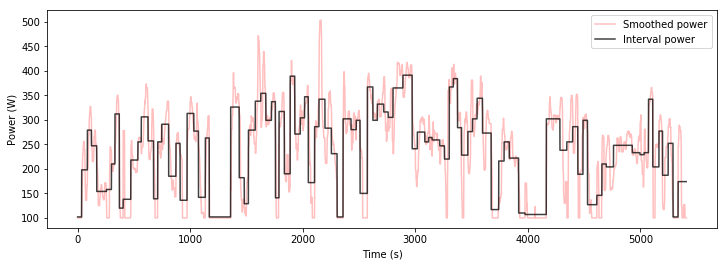

In [41]:
plt.figure(figsize=(12,4))
p1, = plt.plot(sm_p, 'r', alpha=0.25)
p2, = plt.plot(q_p2, 'k', alpha=0.75)
plt.xlabel('Time (s)')
plt.ylabel('Power (W)')
plt.legend([p1, p2],['Smoothed power', 'Interval power'])
plt.show()

<hr>

Now we will write these intervals out to a .zwo file, where they can be followed as a structured workout in Zwift. By default, we will use a name for the .zwo file that concides with the name of the input activity stream file. 

In [42]:
zwo_file = '.'.join(activity_file.split('.')[:-1]) + '.zwo'

Power outputs for intervals in the .zwo file are expressed relative to the user's functional threshold power. So, we need to provide a current FTP value to properly express these intervals

In [43]:
FTP = 341.0

In [44]:
f = open(zwo_file, 'w')

f.write('<?xml version="1.0" ?>\n')
f.write('<workout_file>\n')
f.write('  <workout>\n')
for this_int in intervals:
    f.write('    <SteadyState Duration="%d" Power="%0.2f">'\
          %(this_int[0],float(this_int[1])/FTP))
    f.write('</SteadyState>\n')
f.write('  </workout>\n')
f.write('</workout_file>\n')

f.close()

To see the final output, we can display the contents of the file that was just generated

In [45]:
f = open(zwo_file, 'r')
print(f.read())
f.close()

<?xml version="1.0" ?>
<workout_file>
  <workout>
    <SteadyState Duration="36" Power="0.30"></SteadyState>
    <SteadyState Duration="51" Power="0.58"></SteadyState>
    <SteadyState Duration="36" Power="0.82"></SteadyState>
    <SteadyState Duration="47" Power="0.72"></SteadyState>
    <SteadyState Duration="87" Power="0.45"></SteadyState>
    <SteadyState Duration="44" Power="0.46"></SteadyState>
    <SteadyState Duration="31" Power="0.62"></SteadyState>
    <SteadyState Duration="39" Power="0.91"></SteadyState>
    <SteadyState Duration="34" Power="0.35"></SteadyState>
    <SteadyState Duration="68" Power="0.40"></SteadyState>
    <SteadyState Duration="63" Power="0.64"></SteadyState>
    <SteadyState Duration="30" Power="0.75"></SteadyState>
    <SteadyState Duration="60" Power="0.90"></SteadyState>
    <SteadyState Duration="49" Power="0.75"></SteadyState>
    <SteadyState Duration="37" Power="0.41"></SteadyState>
    <SteadyState Duration="36" Power="0.75"></SteadyState>
    <S